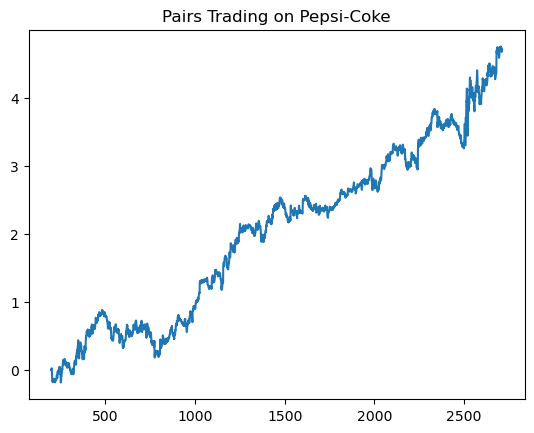


PERFORMANCE STATISTICS FOR MARKET NEUTRAL Stochastic Oscillator
Daily annualized sharpe: 0.7687699770147478
Average annual returns: 3.3101674405701442%
Total returns: 33.062267650456555%
Max drawdown: -7.08563423733441%
Stressed period return during Covid19:  -4.315817769148383%
Stressed period return during Dec18:  0.855647524850151%
Stressed period return during Fall2015:  -0.231521471308607%
Stressed period return during Oct14:  0.03609754917454465%
Stressed period return during Aug2013:  -0.09632982063486394%



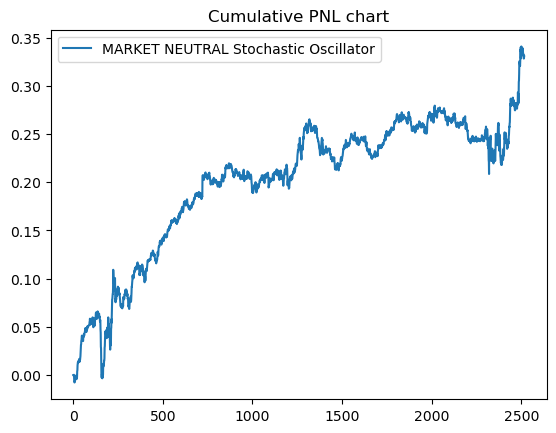


PERFORMANCE STATISTICS FOR MARKET NEUTRAL MACD Crossover
Daily annualized sharpe: 1.7350530522571153
Average annual returns: 14.38261722131991%
Total returns: 143.65495057961195%
Max drawdown: -19.935723669085558%
Stressed period return during Covid19:  -4.7531897159543455%
Stressed period return during Dec18:  0.17589146345440973%
Stressed period return during Fall2015:  0.9743646315603257%
Stressed period return during Oct14:  -0.1603960047477723%
Stressed period return during Aug2013:  -0.5569494183174394%



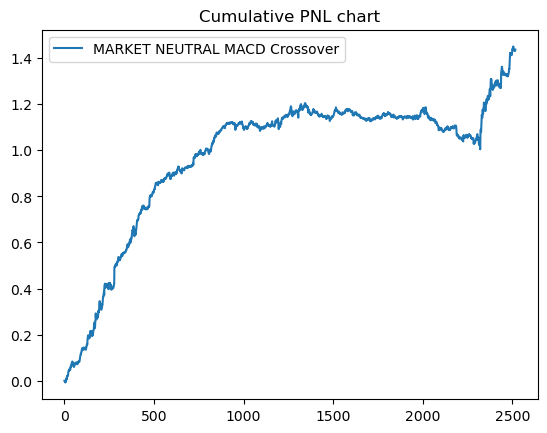

In [1]:
##PAIRS TRADING DEMOSTRATION
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
import os

os.chdir("c:\\smu")

#=======PEP KO Pairs Traidng============================#

russell_df = pd.read_csv("russell1000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
rawdata = {}
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1



import statsmodels.api as sm;
import statsmodels.tsa.stattools as ts
(ts.coint(rawdata['close']['PEP'].iloc[200:2200,], rawdata['close']['KO'].iloc[200:2200,]))[1]
result = sm.OLS(rawdata['close']['PEP'].iloc[200:2200,],sm.add_constant(rawdata['close']['KO'].iloc[200:2200,])).fit()
rawdata['close']['PEPKOspread'] = (rawdata['close']['PEP'] - result.params[1]*rawdata['close']['KO']) -result.params[0]
rawdata['close']['PEPKOposition'] = 0
rawdata['close'].loc[rawdata['close']['PEPKOspread']>0, 'PEPKOposition'] = -1
rawdata['close'].loc[rawdata['close']['PEPKOspread']<0, 'PEPKOposition'] = 1
rawdata['close']['PEPKOposition'] = rawdata['close']['PEPKOposition'].shift(1)
rawdata['close']['PEPposition'] = rawdata['close']['PEPKOposition']
rawdata['close']['KOposition'] = rawdata['close']['PEPKOposition']*result.params[1]*-1
rawdata['close']['dailypnl'] = rawdata['close']['KOposition']*return_df['KO'].shift(-1) + rawdata['close']['PEPposition']*return_df['PEP'].shift(-1)
rawdata['close']['cumpnl'] = rawdata['close']['dailypnl'].cumsum()
plt.plot(rawdata['close']['cumpnl'].values, label = "Pairs Trading on Pepsi-Coke")
plt.title("Pairs Trading on Pepsi-Coke")
plt.show()


#####TECHNICAL ANALYSIS STOCHASTIC OSCILLATOR####


import pandas as pd;
import numpy as np;


#Utility method takes in daily % pnl vector and computes portfolio diagnostics
#daily % pnl is inputed as a dataframe, with date as index and corresponding pnl for that date as the value
def portfolioDiagnostics(signal_df, label):
    #NET SECTOR EXPOSURES
    import matplotlib.pyplot as plt
    plt.figure();
    sector_df = pd.read_csv("sector.csv", on_bad_lines='skip')
    d = sector_df.set_index('ticker').to_dict()
    signal_df2 = signal_df.copy(deep=True)
    signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
    uniquesector = list(set(signal_df2.columns))
    for tsector in uniquesector:
        if (str(tsector)=='nan'):
            continue;
        tmean = signal_df2.loc[:, tsector].sum(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        plt.plot(tmean.values, label=tsector)
        plt.legend();
        plt.title(label+" NET EXPOSURE")
    plt.show(block=False)
    return


#Utility method takes in daily % pnl vector and computes pnl diagnostics
#daily % pnl is inputed as a dataframe, with date as index and corresponding pnl for that date as the value
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")
    #HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    stressedmarkets["Covid19"] = (20200301, 20200317);          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = (20181215, 20181231);            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = (20150701, 20150901);         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = (20141001, 20141031);            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = (20130820, 20130825);          #Flash freeze on 22 Aug 2013

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
    print("===========================")
    print("")


#=======ACTUAL STRATEGY SCRIPT STARTS HERE============================#

russell_df = pd.read_csv("russell2000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
rawdata = {}
period = 20           #NUMBER OF TRADING DAYS TO COMPUTE MEAN REVERSION OVER.  THIS IS A PARAMETER FOR FITTING
universesize = 2000                 #SIZE OF PORTFOLIO IN NUMBER OF STOCKS.  IF THIS IS MORE THAN 2000, IT WILL GENERALLY JUST BE CAPPED AT 2000 SINCE BASE UNIVERSE IS RUSSELL 2000
maxindividualweight = 0.01          #MAXIMUM FRACTION A SINGLE POSITION CAN TAKE UP OF ENTIRE PORTFOLIO.  0.01 MEANS 1%.  i.e. if you have a portfolio of $100 million, max single position size is $1 million

#USING STOCHASTIC OSCILLATOR FOR MR:  MARKET NEUTRAL STRATEGY BASED ON N DAY REVERSION, BASE UNIVERSE IS STOCKS IN RUSSELL 2000
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -(return_df - return_df.rolling(period, min_periods = 3).min()) / (return_df.rolling(period, min_periods = 3).max() - return_df.rolling(period, min_periods = 3).min())
signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)                                              #TO AVOID FORWARD BIAS.  WE USE YESTERDAY'S INFORMATION TO EXECUTE AT TODAY'S CLOSE PRICES
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)                                    #BASED ON YESTERDAY'S INFORMATION, WE EXECUTE AT TODAY'S CLOSE PRICES AND COMPUTE OUR PNL BASED ON TOMORROW'S RETURN
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "MARKET NEUTRAL Stochastic Oscillator")
marketneutralportfolio = signal_df.copy(deep=True)
plt.show(block = False)

#USING MA CROSSOVER:  MOMENTUM SIGNAL
signal_df = -(return_df.rolling(3).mean() - return_df.rolling(period, min_periods = 3).mean())
signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1)                                              #TO AVOID FORWARD BIAS.  WE USE YESTERDAY'S INFORMATION TO EXECUTE AT TODAY'S CLOSE PRICES
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)                                    #BASED ON YESTERDAY'S INFORMATION, WE EXECUTE AT TODAY'S CLOSE PRICES AND COMPUTE OUR PNL BASED ON TOMORROW'S RETURN
pnl = pnl_df.sum(axis=1)
pnlPerformance(pnl, "MARKET NEUTRAL MACD Crossover")
marketneutralportfolio = signal_df.copy(deep=True)
plt.show(block = False)
